## Functional annotation of TotalRNA against CAZy

This notebook is part of the analysis of the TotalRNA   mRNA genes from Trinity.

## How to run Jupyter notebooks in huginn
<details>
<summary>Click to expand!</summary>

If you use vs-code you can use the [remote ssh extension](https://marketplace.visualstudio.com/items?itemName=ms-vscode-remote.remote-ssh) to connect to huginn and either run jupyterlab in the remote server (so to say, just like you would do in your local computer with `jupyter-lab`) or run directly without opening jupyterlab directly. 

Otherwise, you can follow the instructions below: 

1. Turn on VPN
2. Open two terminals (let's called A and B)
3. With terminal A, connect to huginn with ssh as usual
```bash
ssh username@huginn.au.dk
```
4. Move to the directory where you want to work, activate the conda enviroment and run jupyter notebook or jupyter lab:
```bash
conda activate jupyter-diamond
jupyter notebook --no-browser --port=7777
```
5. With terminal B, connect to huginn and forward the port specified port to your local computer
```bash
ssh -Y -N -L localhost:7777:localhost:7777 username@huginn.au.dk
```
6. Open your browser and go to `localhost:7777` and you should see the jupyter notebook running in huginn. You can also press in the url of Terminal A. 

Troubleshooting:
- If you get an error like `bind: Address already in use` it means that you have another jupyter notebook running in the same port. You can either kill the process or change the port.
</details>

## How to create a new environment for this notebook (if needed)

We will use Diamond, a few python basic libraries and bash. Let's check if those dependencies are installed. If not, you can install them with mamba (as well with jupyterlab)

```bash
# To create a new environment with mamba
mamba create -c bioconda -c conda-forge diamond pandas matplotlib jupyterlab -n jupyter-diamond
# To activate the environment
conda activate jupyter-diamond
```

### Sanity check

In [1]:
%%bash
diamond --version
python -c "import pandas; print(pandas.__version__)"
python -c "import matplotlib; print(matplotlib.__version__)"
bash --version | head -n 1

diamond version 2.1.8


2.1.1
3.8.0
GNU bash, version 4.4.20(1)-release (x86_64-pc-linux-gnu)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

The input is the fasta file with contigs and the count table. 

In [3]:
trinity_file = "../data/contigs.fasta"
count_table = "../data/mapped_reads_to_contigs.tsv"
## Sanity check: trinity and count table exit
assert os.path.exists(trinity_file), "Trinity file does not exist"
assert os.path.exists(count_table), "Count table does not exist"

## Run Diamond 

In [4]:
database = "/data_2/Databases/CAZy/CAZyDB.07312019.dmnd"
descriptions_tsv = "/data_2/Databases/CAZy/CAZyDB.07302020.fam-activities.tsv"
outfile_matches = "../results/CAZy_matches.tsv"

In [5]:
%%bash
mkdir -p ../results/

**Please, be aware that, without using any sensitivity option, the default mode is designed for finding hits of >60% identity. Consider increasing the sensitivity (or decreasing it).**

In [6]:
%%bash -s "$database" "$trinity_file" "$outfile_matches"
if [ ! -f $3 ]; then
diamond blastx -p 50 -d $1 -q $2 -o $3 2> /dev/null
fi
head $3

TRINITY_DN226449_c0_g1_i1	NP_176949.1|GH0|3.2.1.51	42.4	99	57	0	64	360	199	297	3.14e-19	85.9


## Parse Diamond output and preprocess

In [7]:
diamond = pd.read_csv(
    outfile_matches,
    delimiter="\t",
    comment="#",
    header=None,
    names=[
        "Query id",
        "Subject id",
        "% identity",
        "alignment length",
        "mismatches",
        "gap openings",
        "q. start",
        "q. end",
        "s. start",
        "s. end",
        "e-value",
        "score",
    ],
)

Now, we have a table with all the alignments between our "genes" and the database.

In [8]:
diamond

,Query id,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
0,TRINITY_DN226449_c0_g1_i1,NP_176949.1|GH0|3.2.1.51,42.4,99,57,0,64,360,199,297,3.140000e-19,85.9


## Read count table
However, we also need to read the count table:

In [9]:
%%bash -s "$count_table"
head $1

ContigID	SampleA	SampleB	SampleC	SampleD	SampleE
TRINITY_DN226500_c0_g1_i1	0	0	2	1	0
TRINITY_DN226510_c0_g1_i1	1	0	0	0	5
TRINITY_DN226477_c0_g1_i1	0	0	0	0	0
TRINITY_DN226449_c0_g1_i1	0	0	2	0	0
TRINITY_DN226457_c0_g1_i1	3	6	0	0	0
TRINITY_DN226454_c0_g1_i1	0	0	0	9	0
TRINITY_DN226455_c0_g1_i1	0	2	0	0	2


In [10]:
counts = pd.read_csv(count_table, sep="\t", comment="#").set_index("ContigID")
counts

,SampleA,SampleB,SampleC,SampleD,SampleE
ContigID,,,,,
TRINITY_DN226500_c0_g1_i1,0,0,2,1,0
TRINITY_DN226510_c0_g1_i1,1,0,0,0,5
TRINITY_DN226477_c0_g1_i1,0,0,0,0,0
TRINITY_DN226449_c0_g1_i1,0,0,2,0,0
TRINITY_DN226457_c0_g1_i1,3,6,0,0,0
TRINITY_DN226454_c0_g1_i1,0,0,0,9,0
TRINITY_DN226455_c0_g1_i1,0,2,0,0,2


## Preprocessing
### Most significant hit per Contig

Now, we need to get the most significant hit per each contig ID. Let's inspect how many hits there are per contig (adjust the number of bins). 

Text(0.5, 1.0, 'Number of hits per contig')

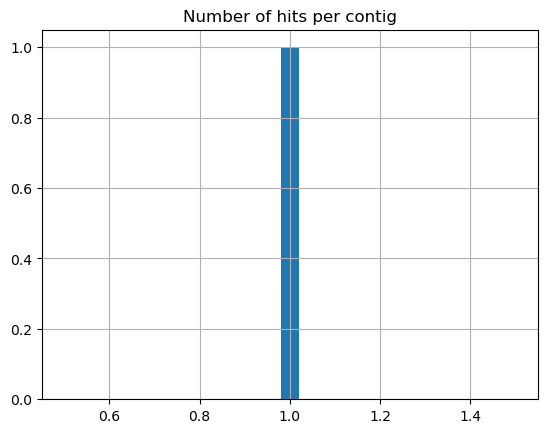

In [11]:
diamond.pivot_table(columns=["Query id"], aggfunc="size").hist(bins=25)
plt.title("Number of hits per contig")

In this case, we are going to sort rows per e-value and score and get the most significant hit per each ContigId.

In [12]:
diamond = (
    diamond.sort_values(by=["e-value", "score"], ascending=[True, False])
    .drop_duplicates("Query id", keep="first")
    .set_index("Query id")
)
diamond

,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
Query id,,,,,,,,,,,
TRINITY_DN226449_c0_g1_i1,NP_176949.1|GH0|3.2.1.51,42.4,99,57,0,64,360,199,297,3.140000e-19,85.9


### Inspect E-values from aligned orthologous genes before filtering by e-value

array([[<Axes: title={'center': 'e-value'}>]], dtype=object)

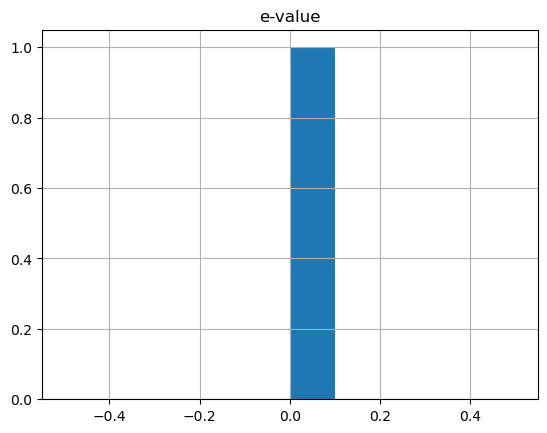

In [13]:
diamond.hist("e-value")

### Inspect E-values from aligned orthologous genes after filtering by e-value

We need to set a threshold:

In [14]:
evalue_threshold = 0.0001

In [15]:
diamond = diamond.loc[diamond["e-value"] < evalue_threshold]

array([[<Axes: title={'center': 'e-value'}>]], dtype=object)

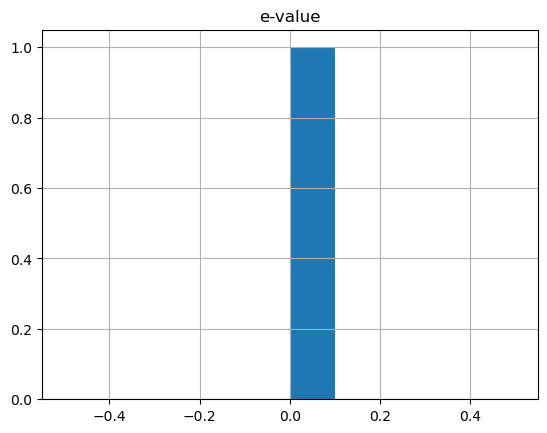

In [16]:
diamond.hist("e-value")

In [17]:
val = len(set(diamond["Subject id"]))
print(f"There are {val} unique orthologous genes")

There are 1 unique orthologous genes


### Inspect % identity and aligment length

array([[<Axes: title={'center': 'alignment length'}>]], dtype=object)

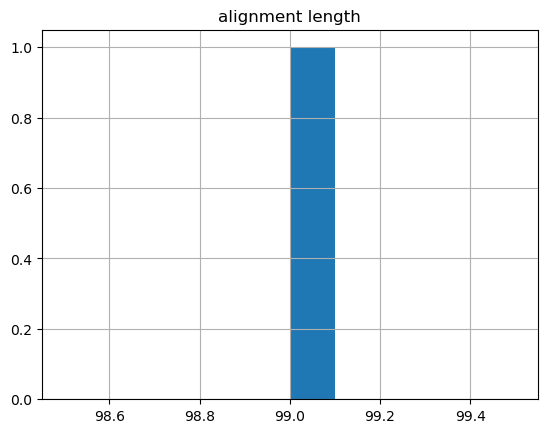

In [18]:
diamond.hist("alignment length")

array([[<Axes: title={'center': '% identity'}>]], dtype=object)

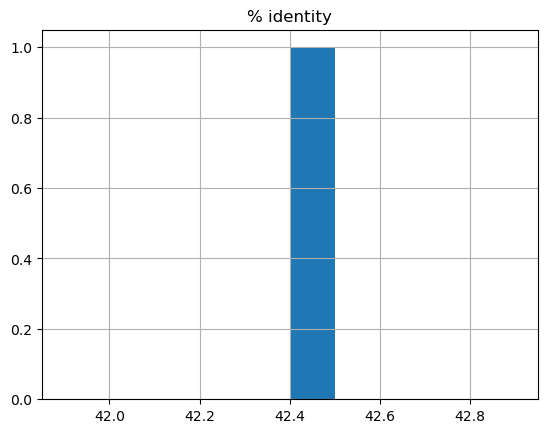

In [19]:
diamond.hist("% identity")

In [20]:
diamond

,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
Query id,,,,,,,,,,,
TRINITY_DN226449_c0_g1_i1,NP_176949.1|GH0|3.2.1.51,42.4,99,57,0,64,360,199,297,3.140000e-19,85.9


Text(0, 0.5, 'Mistmatches')

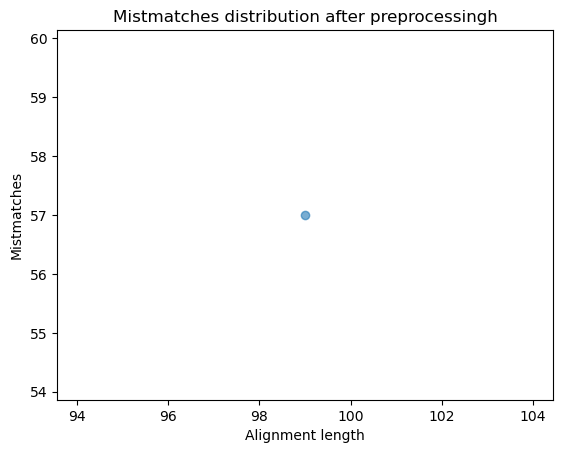

In [21]:
plt.scatter(diamond["alignment length"], diamond.mismatches, alpha=0.6)
plt.title("Mistmatches distribution after preprocessingh")
plt.xlabel("Alignment length")
plt.ylabel("Mistmatches")

## Attention !!
Please, consider the previous information to set the threshold for the e-value and the % identity.

### Merging aligned genes and count table
First, we are going to drop all columns except for ContigsID and orthologous genes header (to obtain map table). 

In [22]:
map_table = diamond[["Subject id"]]
map_table

,Subject id
Query id,
TRINITY_DN226449_c0_g1_i1,NP_176949.1|GH0|3.2.1.51


Now, we are going to merge both files by their column in common (ContigID and Subject id).

In [23]:
df = pd.merge(map_table, counts, left_index=True, right_index=True).reset_index(
    drop=True
)
df

,Subject id,SampleA,SampleB,SampleC,SampleD,SampleE
0,NP_176949.1|GH0|3.2.1.51,0,0,2,0,0


### Aggregate table
Now, we are going to aggregate the rows by grouping by "Subject id" (notice the difference in rows between the previous table and the following):

In [24]:
df = df.groupby("Subject id").sum(numeric_only=True)
df

,SampleA,SampleB,SampleC,SampleD,SampleE
Subject id,,,,,
NP_176949.1|GH0|3.2.1.51,0,0,2,0,0


## Annotating count table

First, we define some helper functions:

In [25]:
import re
import doctest


def extract_CAZyDB_id(x: str) -> list[str]:
    """
    >>> extract_CAZyDB_id('XP_503149.1|GH18')
    ['GH18']
    >>> extract_CAZyDB_id('AAA52077.1|CBM8|3.2.1.4')
    ['CBM8']
    >>> extract_CAZyDB_id('AAA52077.1|CBM8|3.2.1.4|GH18')
    ['CBM8', 'GH18']
    """
    return [elm for elm in x.split("|")[1:] if not re.match(r"^\d", elm)]


def get_annotation_from_CAZyDB_id(x: str) -> str:
    """
    >>> get_annotation_from_CAZyDB_id('GH31')
    'Glycoside Hydrolases'
    >>> get_annotation_from_CAZyDB_id('GT75')
    'GlycosylTransferases'
    >>> get_annotation_from_CAZyDB_id('AA5')
    'Auxiliary Activities'
    >>> get_annotation_from_CAZyDB_id('QAT16263.1')
    ''
    """
    symbols = {
        "GH": "Glycoside Hydrolases",
        "GT": "GlycosylTransferases",
        "PL": "Polysaccharide Lyases",
        "CE": "Carbohydrate Esterases",
        "AA": "Auxiliary Activities",
        "CBM": "Carbohydrate-Binding Modules",
    }
    for k in symbols.keys():
        regex = "^" + k
        if re.match(regex, x):
            return symbols[k]
    return ""


# Run tests
doctest.testmod()

TestResults(failed=0, attempted=7)

In [26]:
df["CAZyDB_id"] = [[y for y in extract_CAZyDB_id(x) if y] for x in df.index]
df

,SampleA,SampleB,SampleC,SampleD,SampleE,CAZyDB_id
Subject id,,,,,,
NP_176949.1|GH0|3.2.1.51,0,0,2,0,0,[GH0]


Now, we want to extend the table by using the CAZyDB_id column (which is a list of list). Every row will have one CAZyDB_id.

In [27]:
df = df.explode("CAZyDB_id")
df

,SampleA,SampleB,SampleC,SampleD,SampleE,CAZyDB_id
Subject id,,,,,,
NP_176949.1|GH0|3.2.1.51,0,0,2,0,0,GH0


Now we can annotate the count table:

In [28]:
df["Level1"] = [get_annotation_from_CAZyDB_id(elm) for elm in df.CAZyDB_id]
df

,SampleA,SampleB,SampleC,SampleD,SampleE,CAZyDB_id,Level1
Subject id,,,,,,,
NP_176949.1|GH0|3.2.1.51,0,0,2,0,0,GH0,Glycoside Hydrolases


And now we add descriptions: 

In [29]:
# Force the tsv in descriptions_tsv to have two columns
descriptions = pd.read_csv(
    descriptions_tsv, sep="\t", comment="#", header=None, names=["CAZyDB_id", "Level2"]
)
descriptions

,CAZyDB_id,Level2
0,AA0,
1,AA10,AA10 (formerly CBM33) proteins are copper-de...
2,AA11,AA11 proteins are copper-dependent lytic pol...
3,AA12,The pyrroloquinoline quinone-dependent oxido...
4,AA13,AA13 proteins are copper-dependent lytic pol...
...,...,...
441,PL5,"alginate lyase (EC 4.2.2.3); endo-beta-1,4-g..."
442,PL6,alginate lyase (EC 4.2.2.3); chondroitinase ...
443,PL7,poly(beta-mannuronate) lyase / M-specific al...
444,PL8,hyaluronate lyase (EC 4.2.2.1); chondroitin ...


In [30]:
# Rename index to ContigID column and drop index
df = df.reset_index().rename(columns={"index": "ContigID"})
# Add the description to the dataframe
df = pd.merge(df, descriptions, on="CAZyDB_id", how="left")

Now, we are going to count the number of enzymes with more than one annotation:

In [31]:
duplicated = (
    df.groupby("Subject id")
    .agg(
        Level1=("Level1", lambda x: "|".join(set(x))),
        types_of_annotation=("Level1", "nunique"),
        n_cazy_ids=("CAZyDB_id", "nunique"),
    )
    .reset_index()
    .loc[lambda x: x.n_cazy_ids > 1]
    .set_index("Subject id")
)
duplicated.to_csv("../results/CAZy_multiple_annotations.tsv", sep="\t")
duplicated

,Level1,types_of_annotation,n_cazy_ids
Subject id,,,


In [32]:
df

,Subject id,SampleA,SampleB,SampleC,SampleD,SampleE,CAZyDB_id,Level1,Level2
0,NP_176949.1|GH0|3.2.1.51,0,0,2,0,0,GH0,Glycoside Hydrolases,Glycoside hydrolases not yet assigned to a f...


In [33]:
df

,Subject id,SampleA,SampleB,SampleC,SampleD,SampleE,CAZyDB_id,Level1,Level2
0,NP_176949.1|GH0|3.2.1.51,0,0,2,0,0,GH0,Glycoside Hydrolases,Glycoside hydrolases not yet assigned to a f...


In [34]:
df.to_csv("../results/CAZy_matches_annotated.tsv", sep="\t", index=False)